# NBA All-Star Classifier - Modelling

## Outlier Addressing and Preprocessing

In [1]:
# data manipulation/visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# modelling and blackbox analysis
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from xgboost import XGBClassifier as XGBC
import shap
from pdpbox import pdp
from scipy.special import expit

# classification metrics and utils
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import roc_curve, plot_confusion_matrix

# basic utils
import os.path
import pickle
from math import exp

from IPython.display import display

pd.options.mode.chained_assignment = None  # default='warn'

# check if this is our first time running the script
# if the model exists from a prior execution, we can load the model from memory instead of retraining it from scratch
already_trained = os.path.exists('./ASG_predictor.model')

# directory to store plots concerning model evaluation and interpretation
if not os.path.exists('./Plots'):
    os.makedirs('./Plots')

# labeled dataset
df_train = pd.read_csv('ASG_train.csv')

# current year's dataset (unlabelled)
df_to_predict = pd.read_csv('ASG_to_predict.csv')

In [2]:
df_train.head(10)

,Year,Avg. Pace,PLAYER,TEAM,Team Conference Rank,GP,Team GP,W,PTS,REB,...,BLK,TOV,TS%,3PM,DEFWS,USG%,PIE,Prior ASG Appearances,AS Last Year?,Selected?
0,1996,90.1,Michael Jordan,CHI,1,40,40,35,30.9,5.8,...,0.5,1.7,56.4,1.2,0.004,33.6,19.8,10,1,1
1,1996,90.1,Shaquille O'Neal,LAL,3,40,41,28,26.2,13.2,...,3.1,3.1,55.7,0.0,0.003,30.4,18.4,4,1,1
2,1996,90.1,Latrell Sprewell,GSW,7,39,39,16,25.9,4.9,...,0.8,4.0,57.1,2.2,0.001,28.2,14.5,2,0,1
3,1996,90.1,Karl Malone,UTA,4,40,40,27,25.8,10.8,...,0.7,3.1,57.6,0.0,0.003,31.5,20.8,9,1,1
4,1996,90.1,Hakeem Olajuwon,HOU,1,37,41,28,24.1,9.4,...,2.2,3.7,54.8,0.1,0.003,32.2,16.3,11,1,1
5,1996,90.1,Mitch Richmond,SAC,8,40,40,16,24.1,3.9,...,0.3,2.8,56.0,1.8,0.002,28.4,14.3,4,1,1
6,1996,90.1,Glen Rice,CHH,6,37,40,21,24.0,4.2,...,0.4,2.2,57.8,2.5,0.002,25.4,11.3,1,1,1
7,1996,90.1,Allen Iverson,PHI,15,34,39,7,22.8,4.5,...,0.4,4.9,50.3,2.2,0.000,29.0,10.3,0,0,0
8,1996,90.1,Vin Baker,MIL,10,36,39,18,22.4,10.7,...,1.4,3.6,56.2,0.2,0.003,26.9,14.2,2,1,1
9,1996,90.1,Gary Payton,SEA,2,40,40,29,22.2,4.4,...,0.1,2.5,55.1,1.4,0.004,26.0,15.6,3,1,1


In [3]:
df_to_predict.head(10)

,Year,Avg. Pace,PLAYER,TEAM,Team Conference Rank,GP,Team GP,W,PTS,REB,...,STL,BLK,TOV,TS%,3PM,DEFWS,USG%,PIE,Prior ASG Appearances,AS Last Year?
0,2019,100.3,James Harden,HOU,6,41,42,26,36.9,6.3,...,1.6,0.9,4.7,62.1,4.8,0.003,37.0,19.4,7,1
1,2019,100.3,Giannis Antetokounmpo,MIL,1,42,45,36,30.0,12.9,...,1.1,1.0,3.6,61.3,1.6,0.004,36.7,23.3,3,1
2,2019,100.3,Trae Young,ATL,15,40,44,9,29.2,4.7,...,1.2,0.1,4.8,59.4,3.5,0.001,33.8,16.4,0,0
3,2019,100.3,Luka Doncic,DAL,5,39,43,25,29.1,9.7,...,1.0,0.2,4.3,59.7,3.0,0.002,36.1,20.6,0,0
4,2019,100.3,Damian Lillard,POR,10,43,45,19,27.9,4.1,...,1.0,0.3,2.8,60.8,3.6,0.002,28.8,16.2,4,1
5,2019,100.3,Bradley Beal,WAS,11,35,42,10,27.2,4.5,...,1.0,0.3,3.3,55.6,2.5,-0.001,31.8,12.6,2,1
6,2019,100.3,Kawhi Leonard,LAC,2,34,44,26,27.1,7.4,...,2.0,0.6,3.2,57.5,1.9,0.003,33.8,19.2,3,1
7,2019,100.3,Devin Booker,PHX,11,40,43,18,26.8,4.1,...,0.8,0.2,3.9,63.2,1.9,0.002,28.9,14.1,0,0
8,2019,100.3,Anthony Davis,LAL,1,36,43,29,26.6,9.3,...,1.5,2.6,2.4,60.5,1.1,0.003,28.6,18.0,6,1
9,2019,100.3,Kyrie Irving,BKN,8,15,42,5,26.5,5.3,...,1.4,0.5,2.2,56.8,2.5,0.001,31.5,16.8,6,1


In [4]:
# pull out the current season from the df for file naming purposes
prediction_year = df_to_predict.loc[0, 'Year'] + 1

# save the PLAYER and TEAM columns for later
# these features get dropped for the prediction process but we will add them back in later for traceability
names_and_teams = df_to_predict[['PLAYER', 'TEAM']]

# manually purging some outliers that are polluting the training data
# (since the dataset is small and our SME is high, this can be done manually - otherwise
# we would perform some automated method like Tukey outlier detection)
#
# these players fall into either one or both of the follwing two cases:
#   A: had long, illustrious careers and were selected in their twilight years as a sort of "farewell",
#      despite not playing at an All-Star level
#   B: sat out way too many games of this season and were only selected due to overpowering clout/fan 
#      favouritism
#
# Note: 'Year' in our dataset refers to the calandar year in which the season started, so the ASG in question 
#       will be equal to 'Year'+1
outliers = set([
    ('Dirk Nowitzki', 2018), # A: Dirk's selection in the 2019 ASG was very much a "respect" pick - career tribute
    ('Kobe Bryant', 2015), # A
    ('Kobe Bryant', 2013), # A/B
    ('Yao Ming', 2010), # B: had all of China rallying for him despite playing in only 5 out of a possible 44 games (11.3%)
    ('Allen Iverson', 2009), # A
    ('Allen Iverson', 2008), # A
    ("Shaquille O'Neal", 2006), # A/B
    ('Ray Allen', 2003), # B
    ('Jamaal Magloire', 2003), # infamously questionable pick
    ('Vince Carter', 2002), # B
    ('Grant Hill', 2000), # B
    ('Anfernee Hardaway', 1997), #A/B
    ('Anfernee Hardaway', 1996) #A/B
])

# stores the indices of our outliers
outlier_indices = []

# gather outlier indices
def process_outliers(row):
    if (row['PLAYER'], row['Year']) in outliers:
        outlier_indices.append(row.name)

# reject the outliers
df_train[['PLAYER', 'Year']].apply(process_outliers, axis=1)
df_train.drop(outlier_indices, inplace=True)

for df in [df_train, df_to_predict]:
    # drop any player who appeared in less than 7 games 
    df.drop(df[df['GP'] < 7].index, inplace=True)

    # the % of team's games the player played in
    # sometimes because of scheduling/trades, a player's indiviual GP may exceed their current team's, so we impose a ceiling of 1
    df['Play Pct.'] = (df['GP'] / df['Team GP']).map(lambda pct : min(pct, 1))

    # nomalized via league average pace for that year
    for col in ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', '3PM']:
        df['Adjusted ' + col] = df[col] / df['Avg. Pace']

# all features to be potentially implemented into the model
#
# during the modelling process, some of the features indictated neglible predictive power
# and were stripped out for the final model
#
# final features used in the model are in the list 'features'
features_full = [
    'Adjusted PTS',
    'Adjusted REB',
    'Adjusted AST',
    'Adjusted STL',
    'Adjusted BLK',
    'Adjusted TOV',
    'Adjusted 3PM',
    'DEFWS',
    'TS%',
    'USG%',
    'PIE',
    'Play Pct.',
    'Team Conference Rank',
    'Prior ASG Appearances',
    'AS Last Year?'
]

# final features used for this model
#
# commented features didn't make the cut
features = [
    'Adjusted PTS',
    'Adjusted REB',
    'Adjusted AST',
    #'Adjusted STL',
    'Adjusted BLK',
    #'Adjusted TOV',
    #'Adjusted 3PM',
    'DEFWS',
    #'TS%',
    'USG%',
    'PIE',
    'Play Pct.',
    'Team Conference Rank',
    'Prior ASG Appearances',
    #'AS Last Year?'
]

# abbreviated versions of the feature names for brevity when we get to SHAP analysis
feature_short_labels = [
    'PTS',
    'REB',
    'AST',
    #'STL',
    'BLK',
    #'TOV',
    #'3PM',
    'DEFWS',
    #'TS%',
    'USG%',
    'PIE',
    'Play%',
    'Team',
    "ASG's",
    #'AS Last Yr.'
]

In [5]:
df_train = df_train[features_full + ['Selected?']]
df_train.head(10)

,Adjusted PTS,Adjusted REB,Adjusted AST,Adjusted STL,Adjusted BLK,Adjusted TOV,Adjusted 3PM,DEFWS,TS%,USG%,PIE,Play Pct.,Team Conference Rank,Prior ASG Appearances,AS Last Year?,Selected?
0,0.342952,0.064373,0.044395,0.017758,0.005549,0.018868,0.013319,0.004,56.4,33.6,19.8,1.000000,1,10,1,1
1,0.290788,0.146504,0.035516,0.009989,0.034406,0.034406,0.000000,0.003,55.7,30.4,18.4,0.975610,3,4,1,1
2,0.287458,0.054384,0.067703,0.019978,0.008879,0.044395,0.024417,0.001,57.1,28.2,14.5,1.000000,7,2,0,1
3,0.286349,0.119867,0.052164,0.014428,0.007769,0.034406,0.000000,0.003,57.6,31.5,20.8,1.000000,4,9,1,1
4,0.267481,0.104329,0.029967,0.016648,0.024417,0.041065,0.001110,0.003,54.8,32.2,16.3,0.902439,1,11,1,1
5,0.267481,0.043285,0.041065,0.014428,0.003330,0.031077,0.019978,0.002,56.0,28.4,14.3,1.000000,8,4,1,1
6,0.266371,0.046615,0.022198,0.009989,0.004440,0.024417,0.027747,0.002,57.8,25.4,11.3,0.925000,6,1,1,1
7,0.253052,0.049945,0.075472,0.025527,0.004440,0.054384,0.024417,0.000,50.3,29.0,10.3,0.871795,15,0,0,0
8,0.248613,0.118757,0.026637,0.011099,0.015538,0.039956,0.002220,0.003,56.2,26.9,14.2,0.923077,10,2,1,1
9,0.246393,0.048835,0.079911,0.026637,0.001110,0.027747,0.015538,0.004,55.1,26.0,15.6,1.000000,2,3,1,1


## Exploratory Data Analysis

In [6]:
df_train.describe()

,Adjusted PTS,Adjusted REB,Adjusted AST,Adjusted STL,Adjusted BLK,Adjusted TOV,Adjusted 3PM,DEFWS,TS%,USG%,PIE,Play Pct.,Team Conference Rank,Prior ASG Appearances,AS Last Year?,Selected?
count,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000
mean,0.093178,0.040784,0.020480,0.007416,0.004843,0.013802,0.006257,0.001691,51.427884,18.266187,8.603678,0.760838,7.873658,0.499200,0.060886,0.063628
std,0.064811,0.027650,0.019853,0.005018,0.005534,0.008932,0.007277,0.001262,7.408872,4.969978,3.945267,0.249420,4.290575,1.715664,0.239136,0.244103
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003000,0.000000,4.300000,-16.700000,0.145833,1.000000,0.000000,0.000000,0.000000
25%,0.042242,0.020652,0.006572,0.003330,0.001099,0.007000,0.000000,0.001000,47.800000,14.800000,6.300000,0.589744,4.000000,0.000000,0.000000,0.000000
50%,0.077670,0.034079,0.014024,0.006522,0.003236,0.011944,0.003300,0.001000,52.100000,17.800000,8.700000,0.853659,8.000000,0.000000,0.000000,0.000000
75%,0.130862,0.053905,0.027203,0.009923,0.006390,0.018785,0.010741,0.002000,55.800000,21.500000,10.900000,0.975610,12.000000,0.000000,0.000000,0.000000
max,0.384530,0.183130,0.142237,0.032223,0.048405,0.060166,0.053000,0.014000,105.000000,40.700000,28.600000,1.000000,15.000000,16.000000,1.000000,1.000000


In [7]:
husl = sns.color_palette('husl')
# 0 = non all-star: red
# 1 = all-star: green
palette = {
    0 : husl[0],
    1 : husl[3]
}

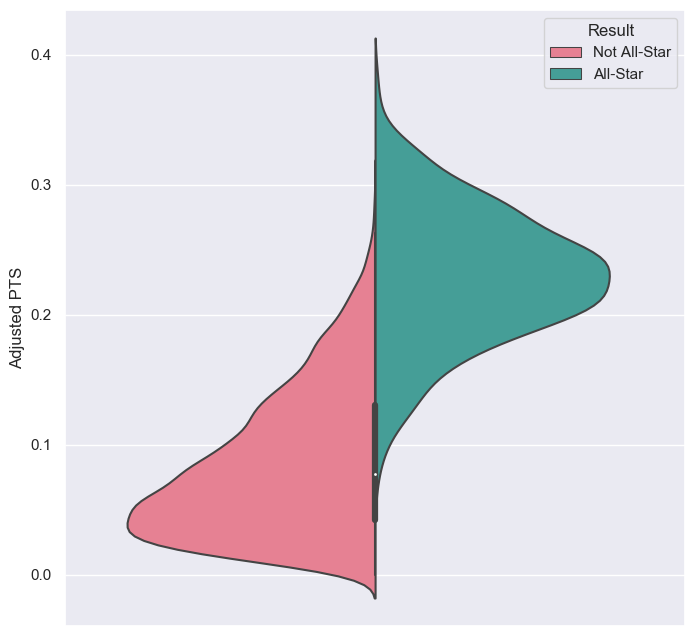

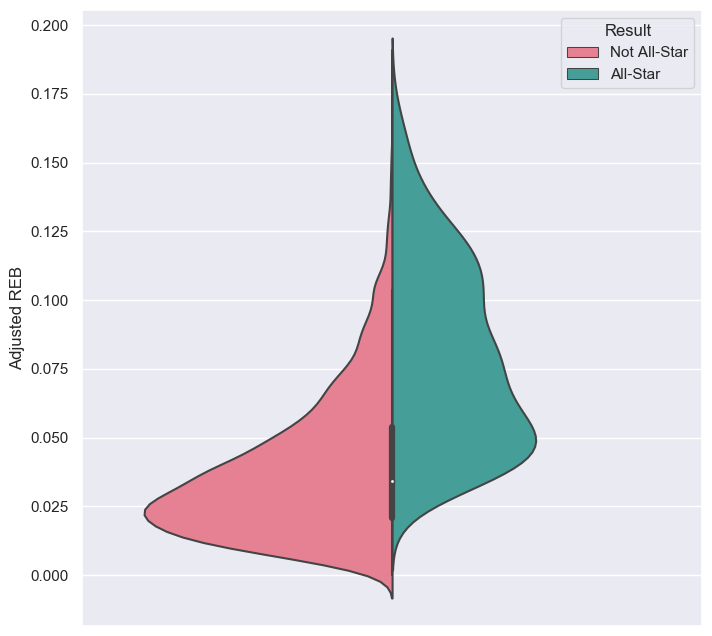

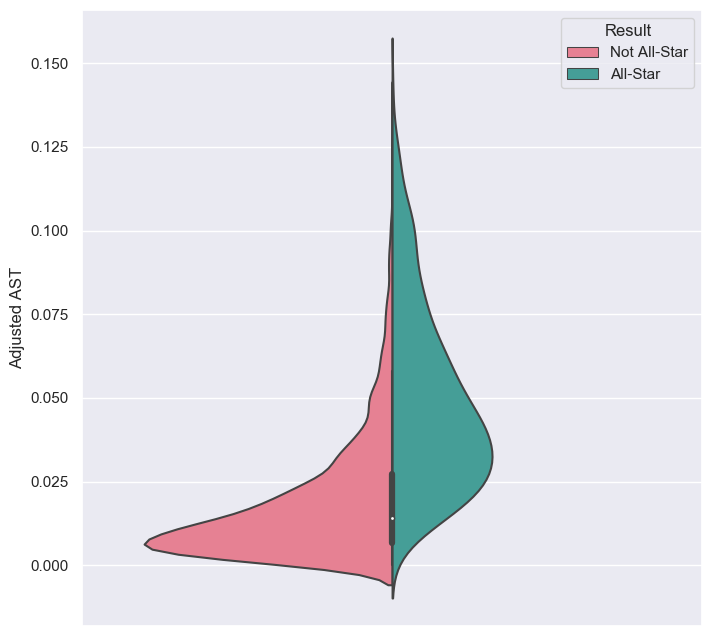

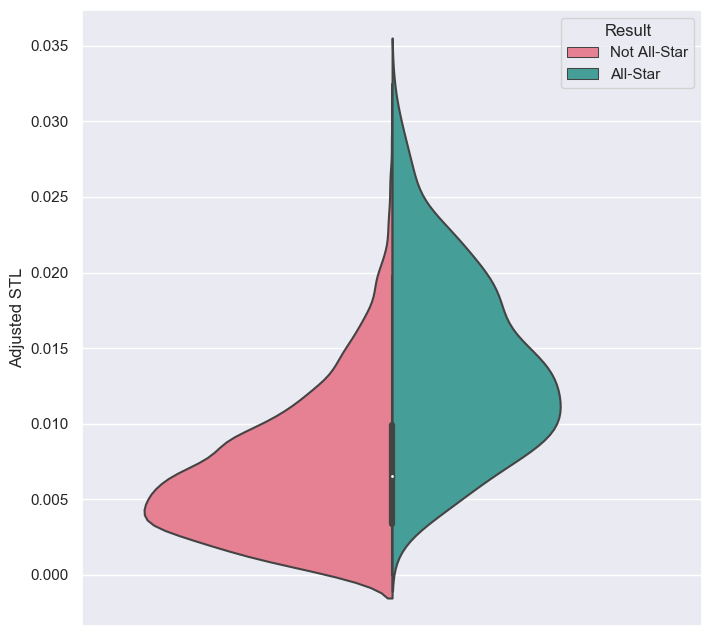

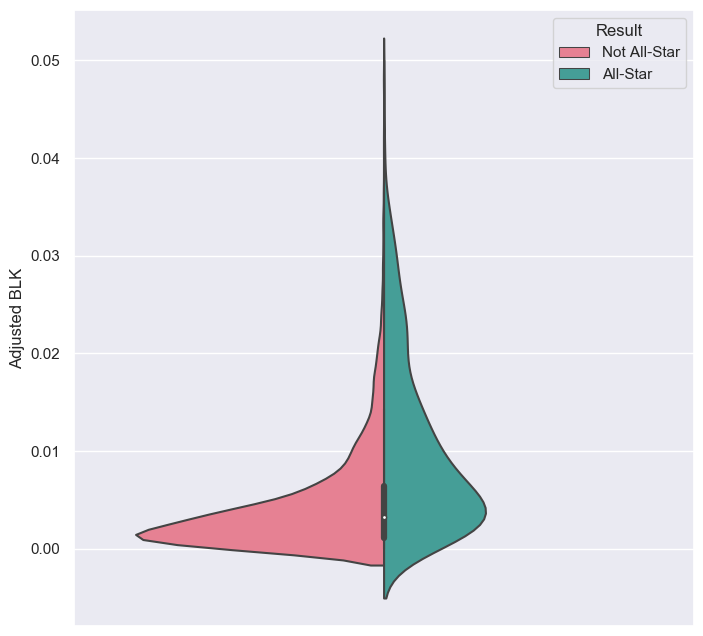

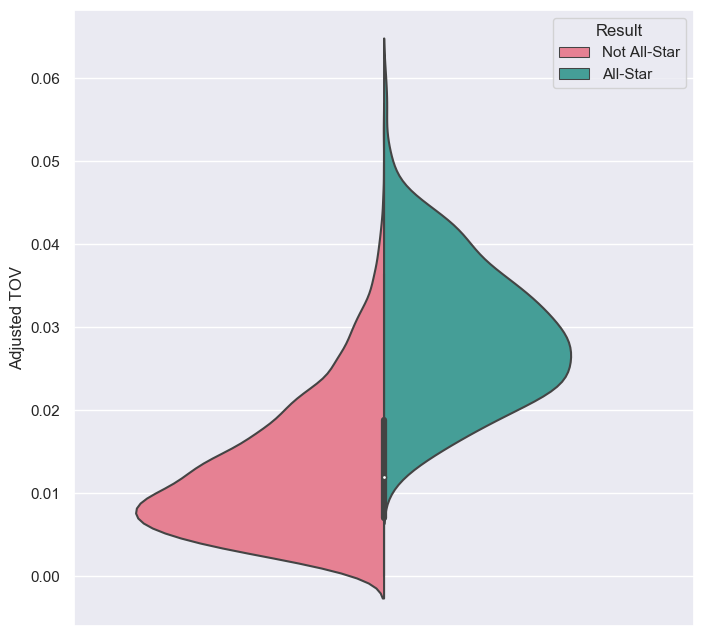

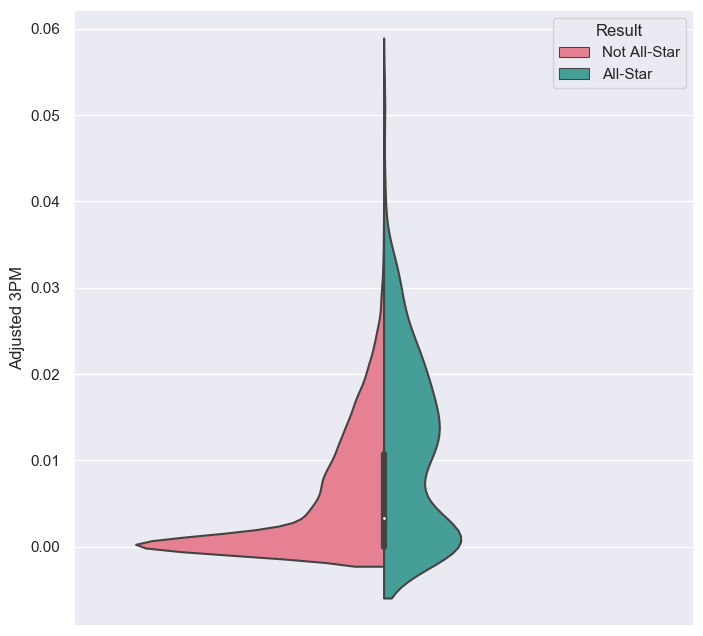

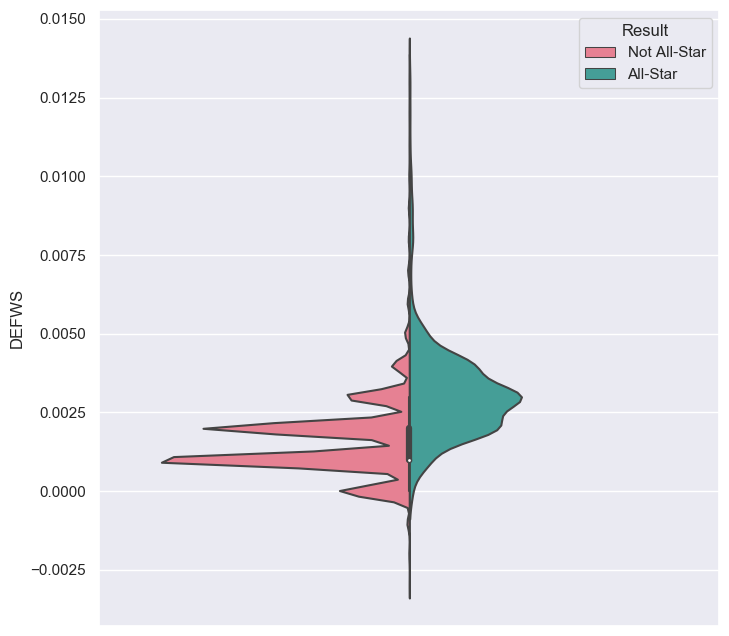

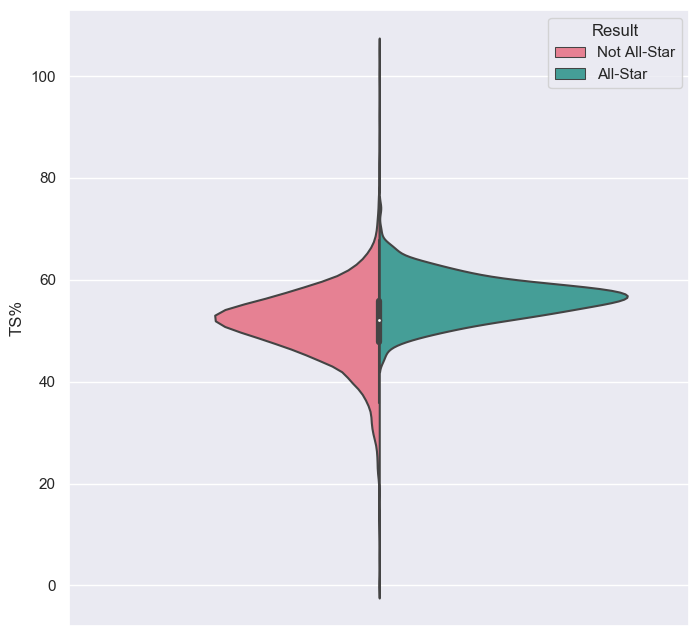

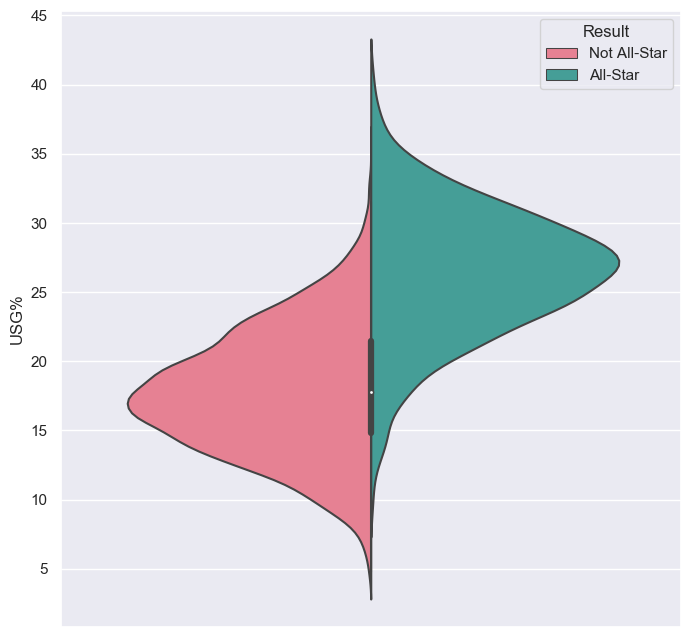

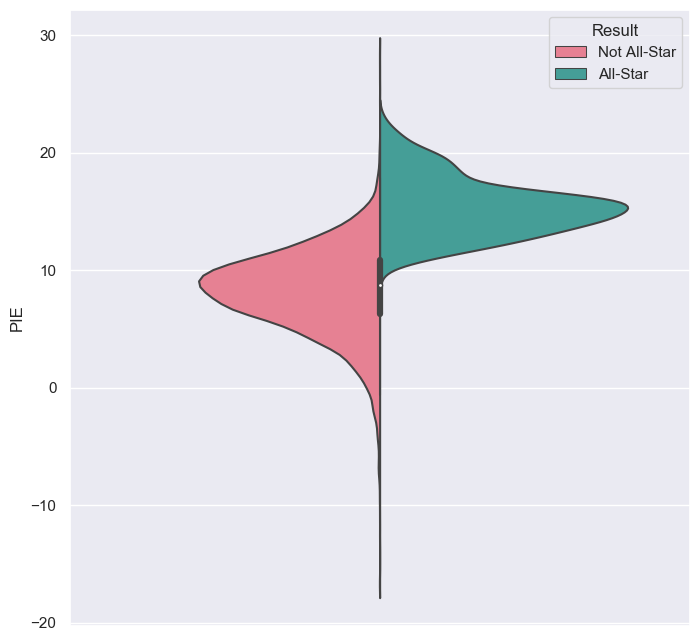

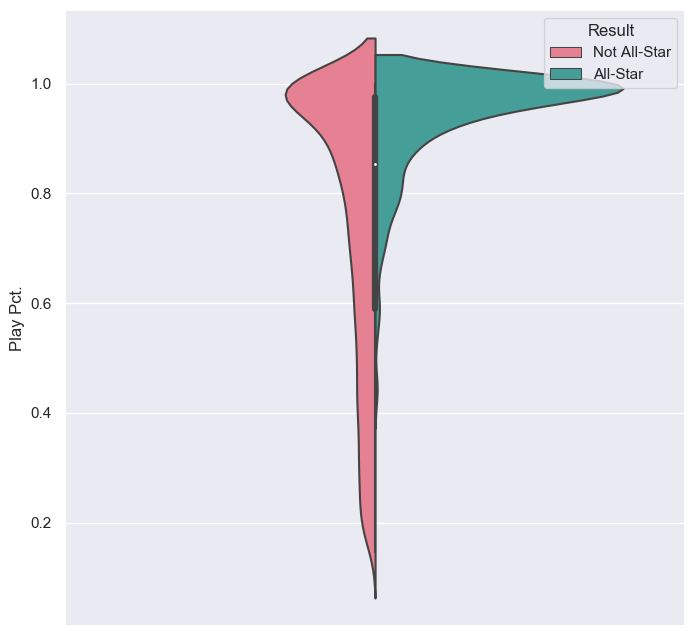

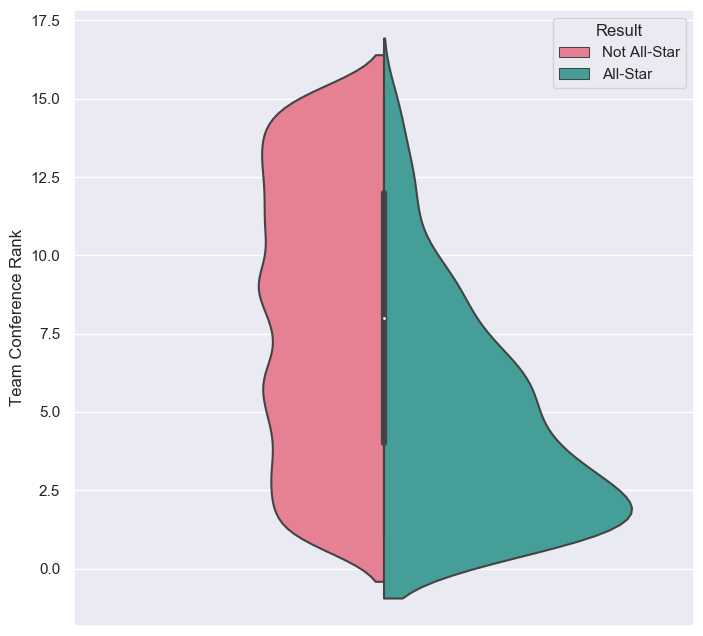

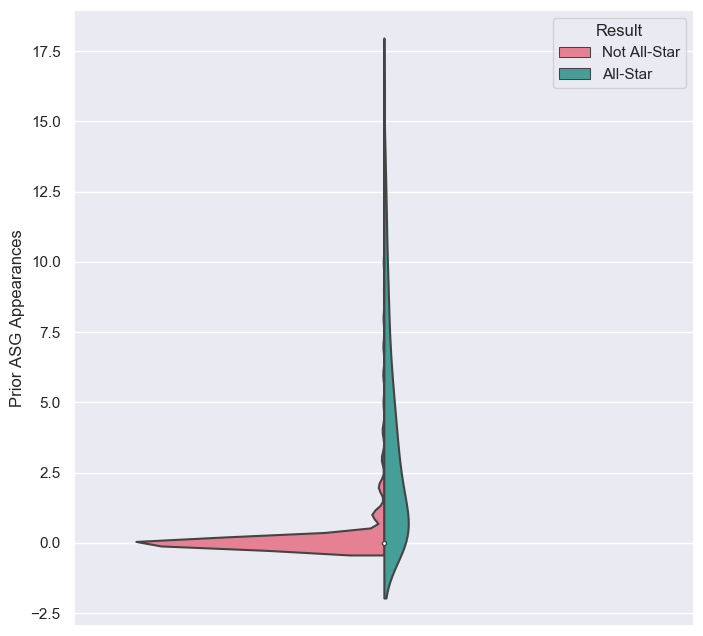

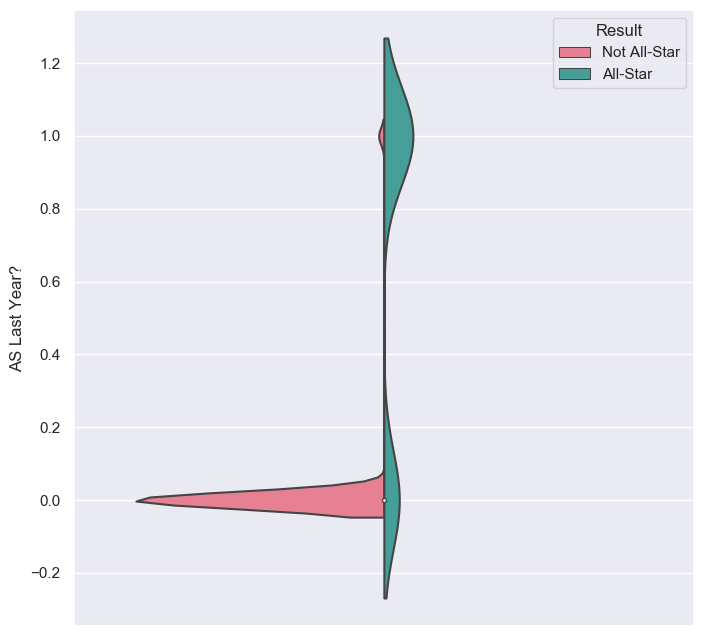

In [8]:
plt.style.use('default')
sns.set(style='darkgrid')
plt.rcParams['legend.title_fontsize'] = 'medium'

for feat in features_full:
    fig, ax = plt.subplots(figsize=(8,8))
    sns.violinplot(ax=ax, data=df_train, y=feat, x=[''] * len(df_train), hue='Selected?', split=True, palette=palette)
    ax.legend_.set_title('Result')
    new_labels = ['Not All-Star', 'All-Star']
    for t, l in zip(ax.legend_.texts, new_labels):
        t.set_text(l)
    feat = feat.replace('?', '').replace('%', '')
    plt.savefig('./Plots/{}-violinplot.png'.format(feat))
    plt.show()

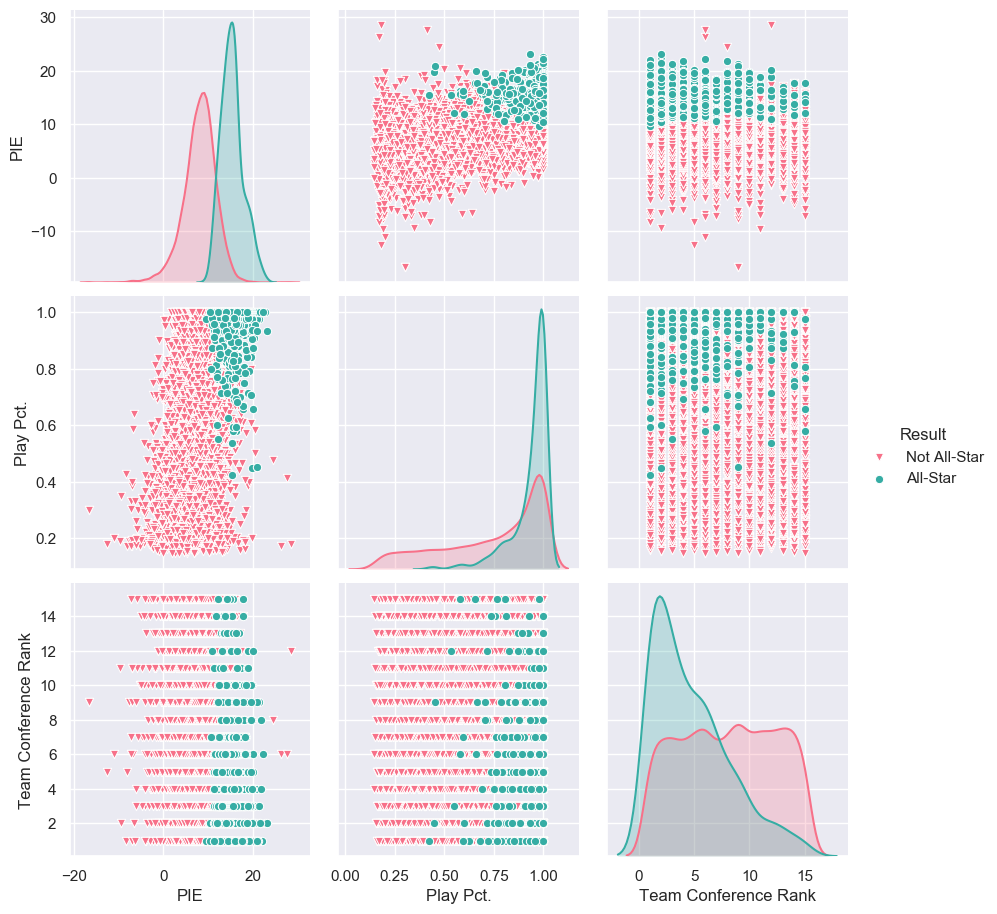

In [9]:
pairplot_features = [
    'PIE',
    'Play Pct.',
    'Team Conference Rank'
]

ax = sns.pairplot(data=df_train, vars=pairplot_features, hue='Selected?', markers=['v', 'o'], palette=palette, size=3)
ax._legend.set_title('Result')
new_labels = ['Not All-Star', 'All-Star']
for t, l in zip(ax._legend.texts, new_labels):
    t.set_text(l)
plt.subplots_adjust(right=0.85)
plt.savefig('./Plots/scattermatrix.png')
plt.show()

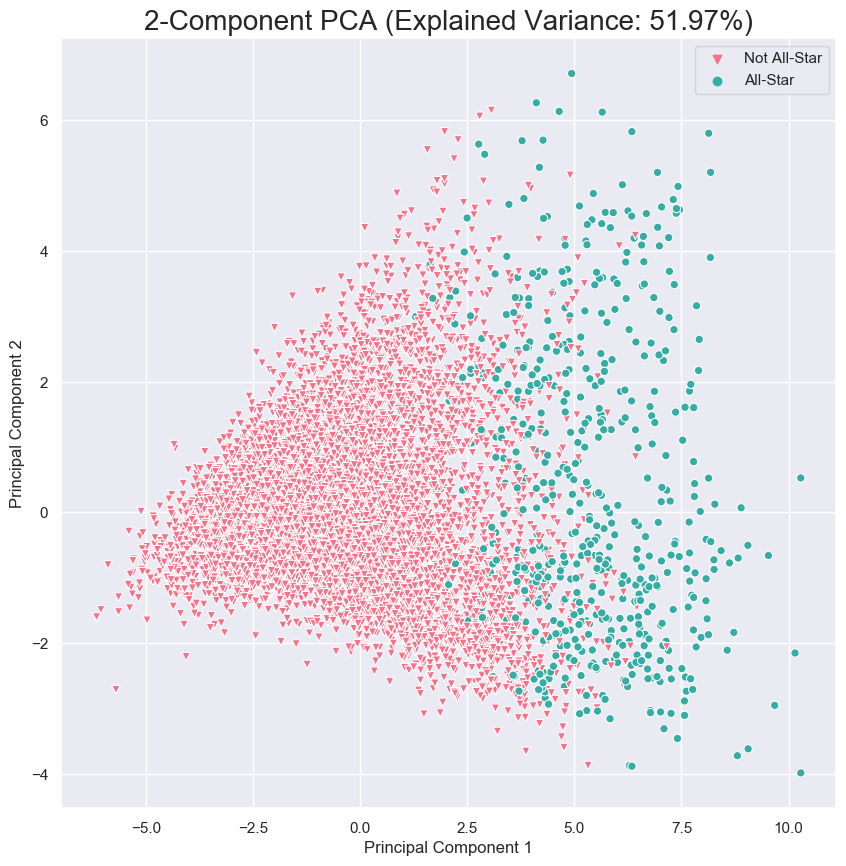

In [10]:
pca = PCA(n_components=2)

X_pca = df_train[features_full].values
y_pca = df_train['Selected?'].values

X_pca = StandardScaler().fit_transform(X_pca)

components = pca.fit_transform(X_pca)
df_pca = pd.DataFrame(data=components, columns=['Principal Component 1',
                                                'Principal Component 2'])
df_pca['Result'] = y_pca

explained_variance = 100*sum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(ax=ax, data=df_pca, x='Principal Component 1', y='Principal Component 2',
                markers=['v', 'o'], style='Result', hue='Result', palette=palette)
ax.set_title('2-Component PCA (Explained Variance: {:.2f}%)'.format(explained_variance), size=20)
new_labels = ['Not All-Star', 'All-Star']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=new_labels)
plt.savefig('./Plots/PCA.png')
plt.show()

## Partitioning Labeled Dataset

In [11]:
# split labeled data into 66% train, 17% validation, 17% test
train, non_train = train_test_split(df_train, train_size=0.66, stratify=df_train['Selected?'], shuffle=True, random_state=0)
validation, test = train_test_split(non_train, train_size=0.5, stratify=non_train['Selected?'], shuffle=True, random_state=0)

X_train, y_train = train[features], train['Selected?']
X_val, y_val = validation[features], validation['Selected?']
X_test, y_test = test[features], test['Selected?']

tuned_model = None

## Tuning XGBoost Hyperparameters

In [12]:
# performed only during first execution for model tuning purposes - trains the model
if not already_trained:

    #print(y_train.value_counts())
    #
    #
    # we use SMOTE (synthetic minority oversampling technique) to balance out our output classes
    #
    # in our training data, there are 5409 non all-stars and only 368 all-stars, so a crude blanket strategy labelling
    # everyone as a non-all star would still achieve 93.6% accuracy
    #
    # SMOTE will create synthetic data points in the all-star class so that the classes are balanced
    X_train_oversampled, y_train_oversampled = BorderlineSMOTE(random_state=0).fit_sample(X_train, y_train)

    # range of learning rates we will consider
    learning_rates = [a * (10**b) for b in range(-6, -1) for a in range(1, 10)] + [0.1]

    # maximum number of rounds we will consider
    max_n_estimators = 2500
    # number of rounds after which to terminate the process if no improvement is seen (patience)
    early_stopping_rounds = 10
    # maximum depth of the decision tree - kept very low to avoid overfitting and ensure a relatively "simple" model
    max_depth = 2

    best_learning_rate, best_ntree_limit = learning_rates[0], 1
    highest_auc = -float('inf')

    for learning_rate in learning_rates:

        model = XGBC(objective='binary:logistic', learning_rate=learning_rate,
                     n_estimators=max_n_estimators, max_depth=max_depth, n_jobs=-1, random_state=0)
        model.fit(X=X_train_oversampled, y=y_train_oversampled, eval_metric=['error', 'logloss', 'auc'],
                  eval_set=[(X_train_oversampled, y_train_oversampled), (X_val, y_val)],
                  early_stopping_rounds=early_stopping_rounds, verbose=True)
        curr_auc = max(model.evals_result()['validation_1']['auc']) # AUC of the validation set
        if curr_auc > highest_auc:
            highest_auc, best_learning_rate, best_ntree_limit = curr_auc, learning_rate, model.best_ntree_limit

    # train the model with the optimal hyperparameters
    tuned_model = XGBC(objective='binary:logistic', learning_rate=best_learning_rate, n_estimators=best_ntree_limit,
                       max_depth=max_depth, n_jobs=-1, random_state=0)
    tuned_model.fit(X=X_train_oversampled, y=y_train_oversampled, eval_metric=['error', 'logloss', 'auc'],
                    eval_set=[(X_train_oversampled, y_train_oversampled), (X_val, y_val)],
                    early_stopping_rounds=early_stopping_rounds, verbose=True)

    # serialize the model and export to local memory
    pickle.dump(tuned_model, open('ASG_predictor.model', 'wb'))

In [13]:
tuned_model = pickle.load(open('ASG_predictor.model', 'rb'))

# run the tuned model on the test set and get all-star prediction probabilities
y_test_proba = [prob[1] for prob in tuned_model.predict_proba(X_test)]

# shows model performance progress during training and how it fares with the test set
def show_model_evaluations():

    plt.style.use('bmh')

    results = tuned_model.evals_result()
    epochs = len(results['validation_0']['auc'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['auc'], label='Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
    plt.title('XGBoost AUC ({} epochs)'.format(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    ax.legend()
    plt.savefig('./Plots/AUC-training.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Validation')
    plt.title('XGBoost Error% ({} epochs)'.format(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Error%')
    ax.legend()
    plt.savefig('./Plots/error-training.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
    plt.title('XGBoost Logarithmic Loss ({} epochs)'.format(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Log. Loss')
    ax.legend()
    plt.savefig('./Plots/logloss-training.png')
    plt.show()

    plt.style.use('default')
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(8,8))
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    no_skill = [0] * len(y_test)
    fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_test, no_skill)
    ax.plot(fpr, tpr, label='XGBoost')
    ax.plot(fpr_ns, tpr_ns, linestyle='--', label='No Skill')
    plt.title('XGBoost Receiver Operating Characteristic\n(AUC = {:.4f})'.format(roc_auc_score(y_test, y_test_proba)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend()
    plt.savefig('./Plots/ROCAUC.png')
    plt.show()

    plt.style.use('default')
    plt.style.use('seaborn-deep')

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#FFFFFF', '#264d73'])
    fig, ax = plt.subplots(figsize=(8,8))
    plot_confusion_matrix(tuned_model, X_test, y_test, cmap=cmap, display_labels=['Not AS', 'All Star'], normalize='true', ax=ax)
    plt.title('Normalized confusion matrix\n')
    plt.savefig('./Plots/confusion.png')
    plt.show()


def show_model_interpretation():
    
    # uses SHAP values to "explain" the model robustly
    # SHAP provides model inteprtation metrics that are accurate and consistent (unlike gain, cover or weight)
    explainer = shap.TreeExplainer(tuned_model)
    shap_values = explainer.shap_values(X_train)
    
    plt.style.use('seaborn-deep')

    shap.summary_plot(shap_values, X_train, plot_type='dot', plot_size=(12,8), show=False)
    plt.subplots_adjust(left=0.3)
    plt.title('Model SHAP Details')
    plt.savefig('./Plots/SHAP-Details.png')
    plt.show()

    shap.summary_plot(shap_values, X_train, plot_type='bar', color='#264d73', plot_size=(12,8), show=False)
    plt.subplots_adjust(left=0.22)
    plt.title('Model SHAP Summary')
    plt.savefig('./Plots/SHAP-Summary.png')
    plt.show()

    partial_dependence_features = ['PIE', 'Team Conference Rank', 'Play Pct.']
    for i, feature in enumerate(partial_dependence_features):
        pdp_feature = pdp.pdp_isolate(model=tuned_model, dataset=X_test, model_features=X_test.columns.tolist(), feature=feature)
        fig, ax = pdp.pdp_plot(pdp_feature, feature, figsize=(10,8))
        plt.savefig('./Plots/indiviual-pdp-{}.png'.format(i+1))
        plt.show()
    
    interaction_features = (['PIE', 'Team Conference Rank'], ['PIE', 'Play Pct.'])
    for i, pair in enumerate(interaction_features):
        interaction = pdp.pdp_interact(model=tuned_model, dataset=X_test, model_features=X_test.columns.tolist(), features=pair)
        fig, ax = pdp.pdp_interact_plot(pdp_interact_out=interaction, feature_names=pair, plot_type='contour', figsize=(10,8))
        plt.savefig('./Plots/interaction-pdp-{}.png'.format(i+1))
        plt.show()

        
def show_classification_metrics():

    # range of classification thresholds to consider
    thresholds = np.arange(0.1, 1, 0.0025)

    highest_f1_score = -float('inf')
    optimal_threshold = thresholds[0]
    for threshold in thresholds:
        y_pred = [0 if prob < threshold else 1 for prob in y_test_proba]
        curr_f1_score = f1_score(y_test, y_pred)
        if curr_f1_score > highest_f1_score:
            highest_f1_score = curr_f1_score
            optimal_threshold = threshold

    # our binary-forced predictions based upon our F1-score-optimized threshhold
    y_pred = [0 if prob < optimal_threshold else 1 for prob in y_test_proba]

    metrics = [
        'Accuracy',
        'Precision',
        'Recall',
        'F1 Score',
        'Log. Loss',
        'ROC AUC'
    ]

    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        log_loss(y_test, y_test_proba),
        roc_auc_score(y_test, y_test_proba)
    ]

    df_classification_metrics = pd.DataFrame({'Metric' : metrics, 'Score' : scores}).set_index('Metric')

    return df_classification_metrics

## Model Learning Evaluation and Performance

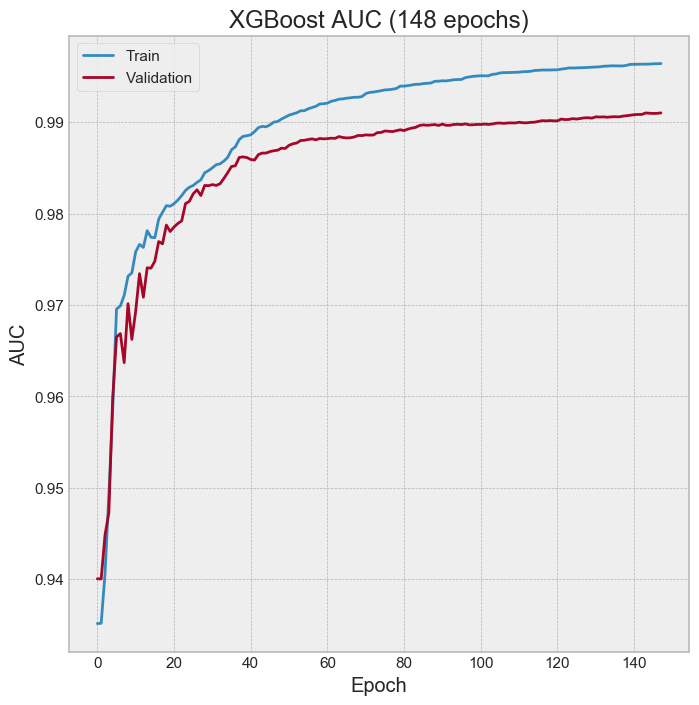

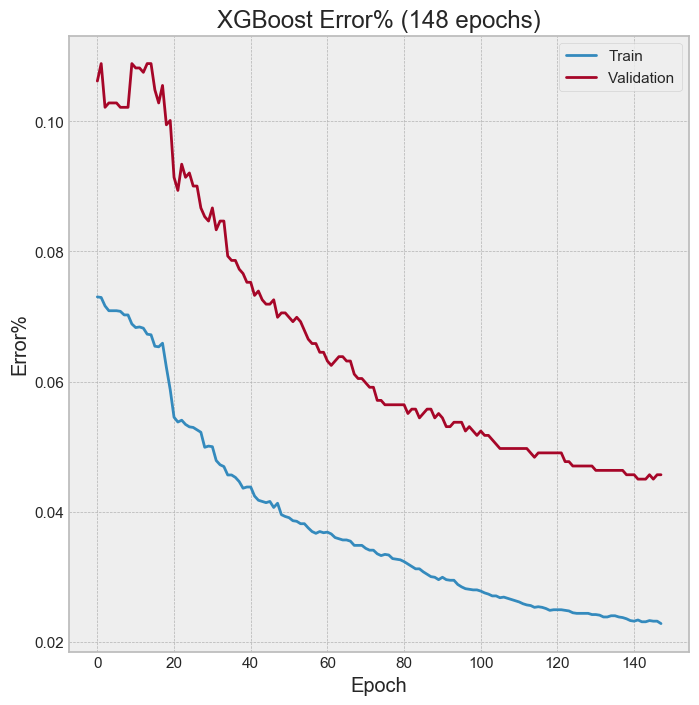

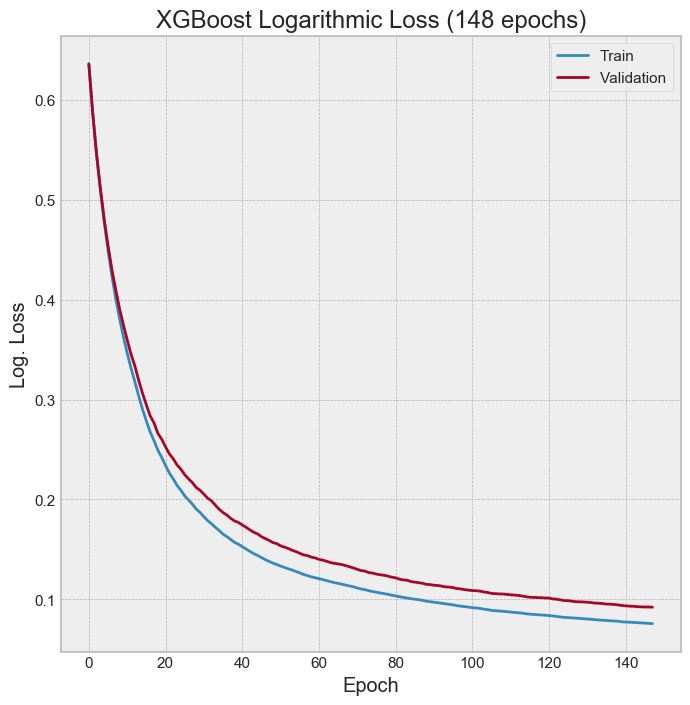

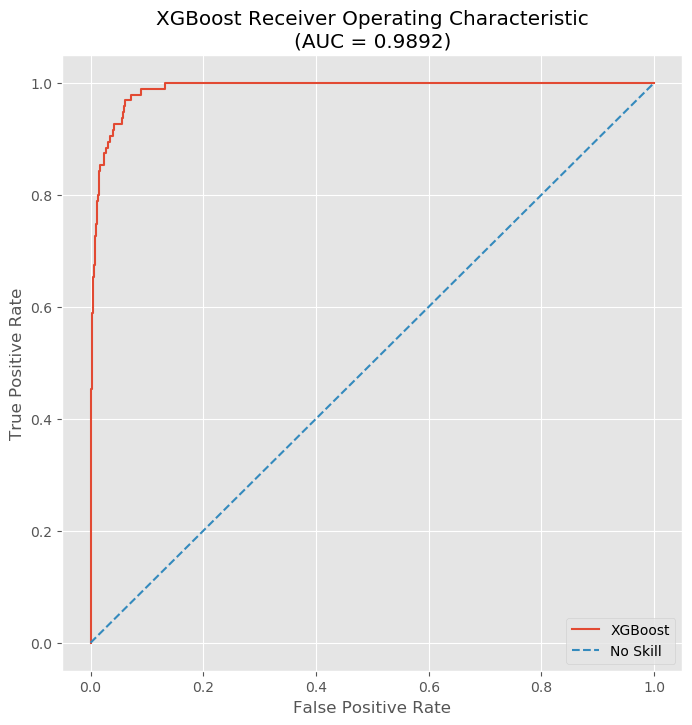

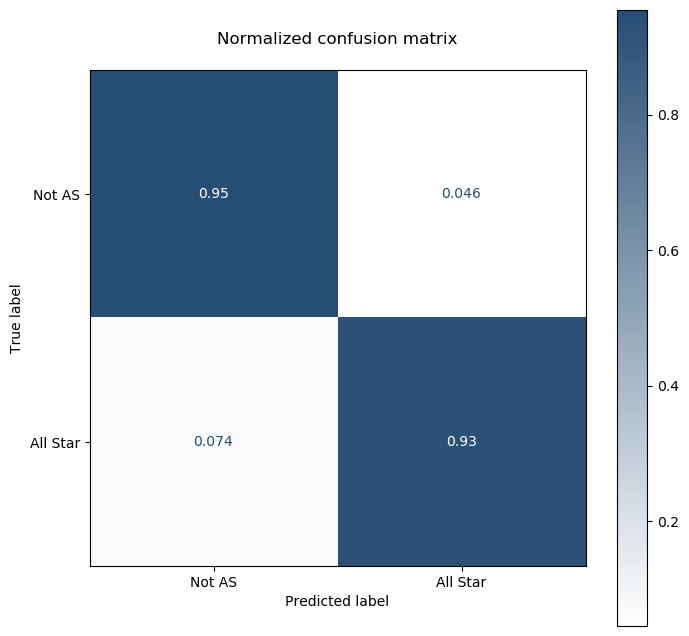

In [14]:
show_model_evaluations()

## Model Interpretation using SHAP Values and Partial Dependance

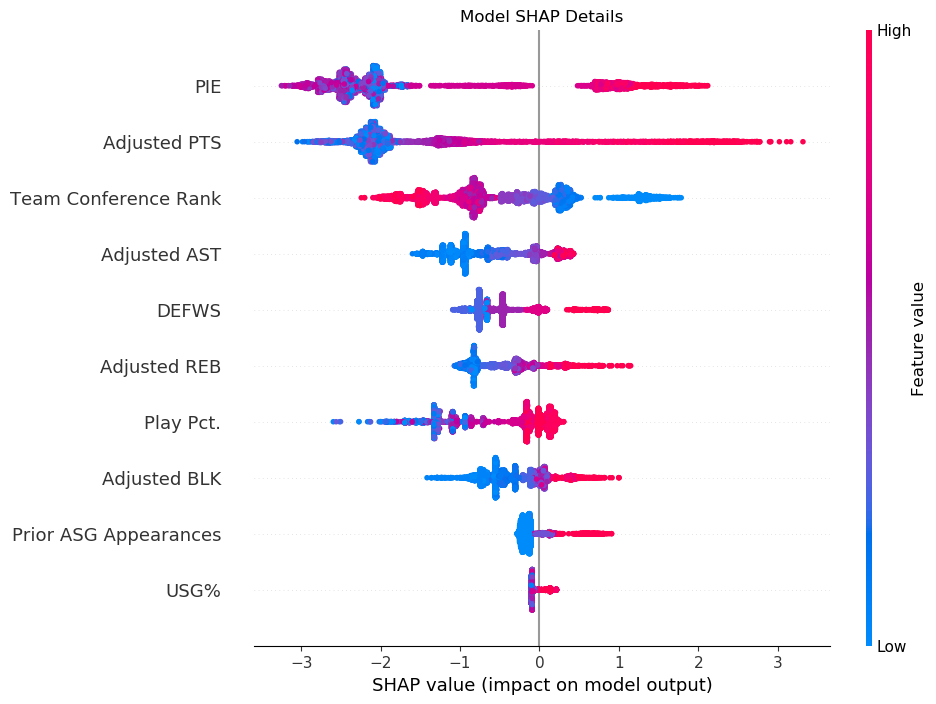

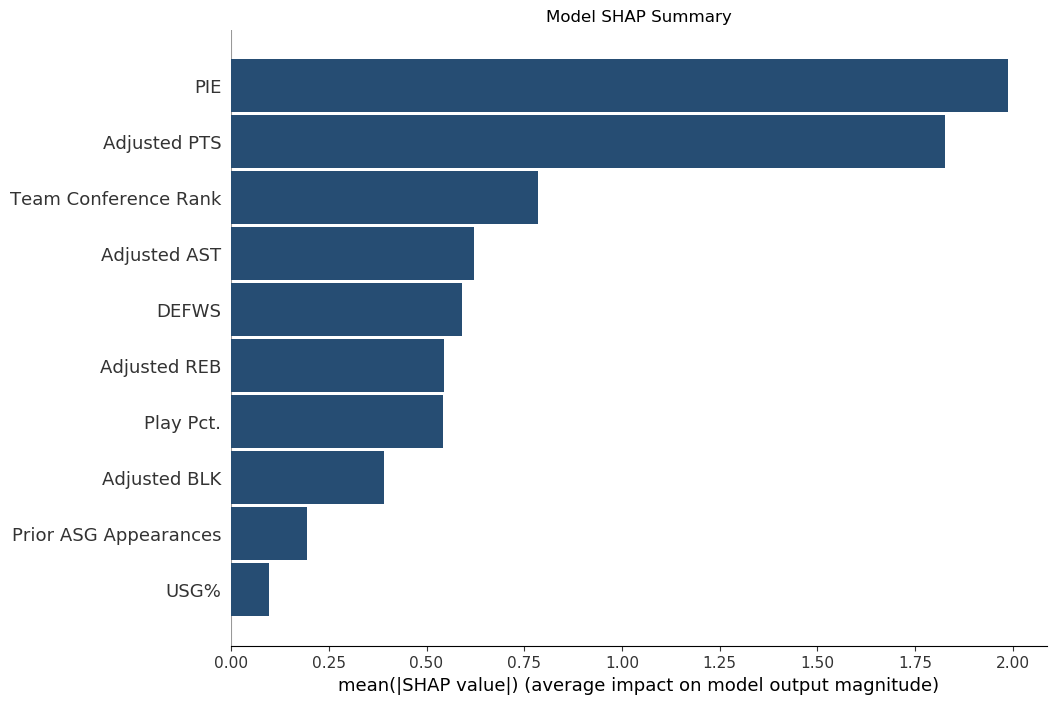

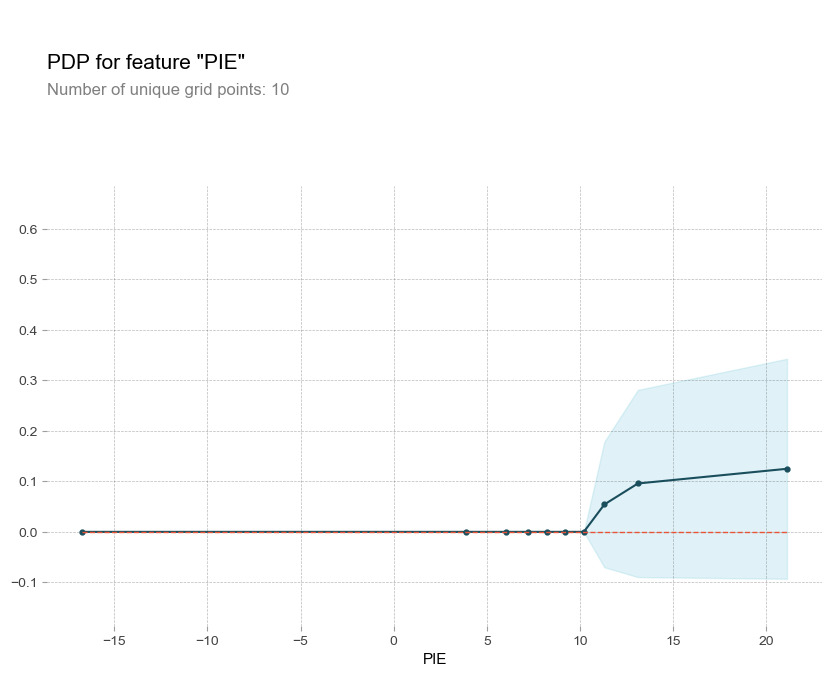

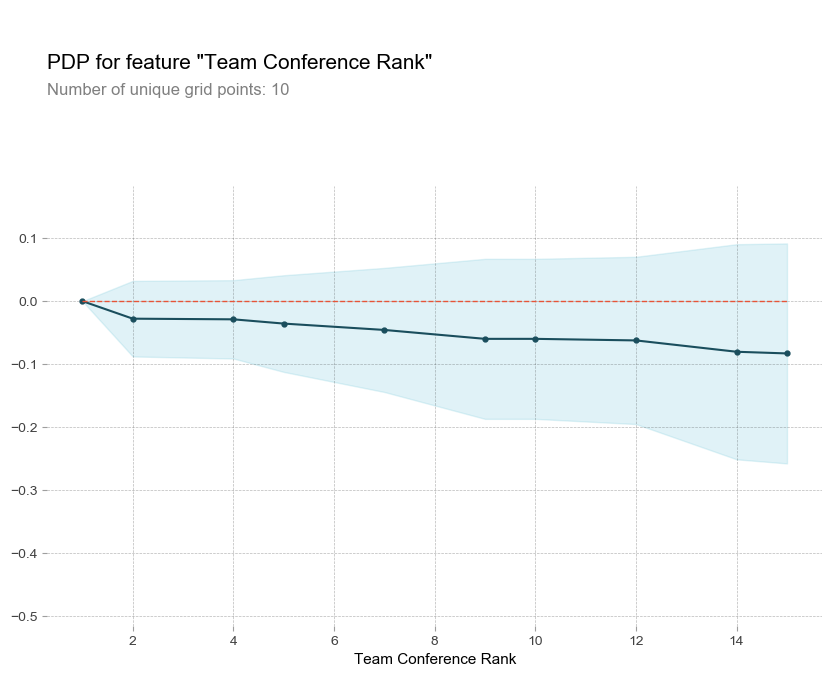

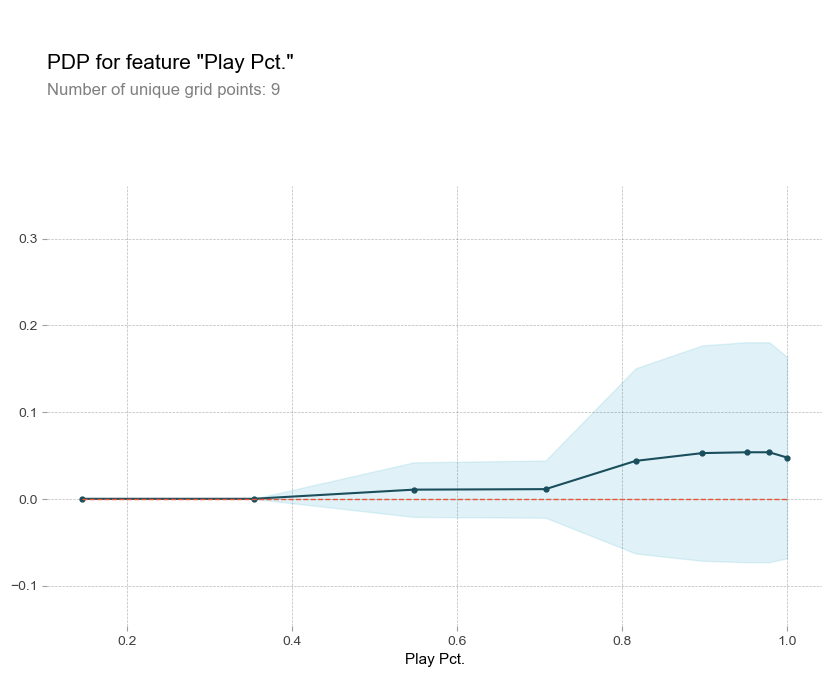

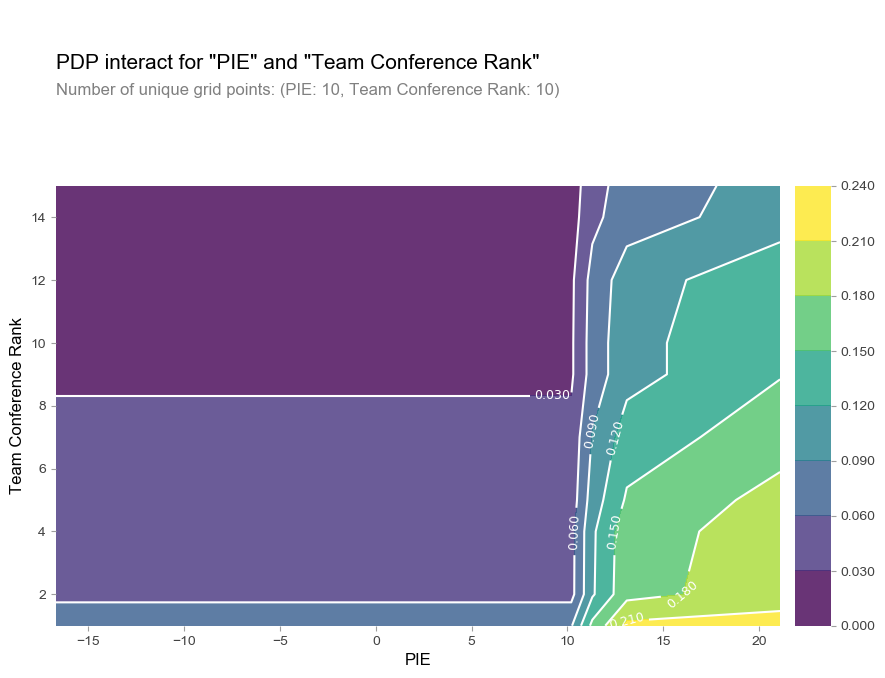

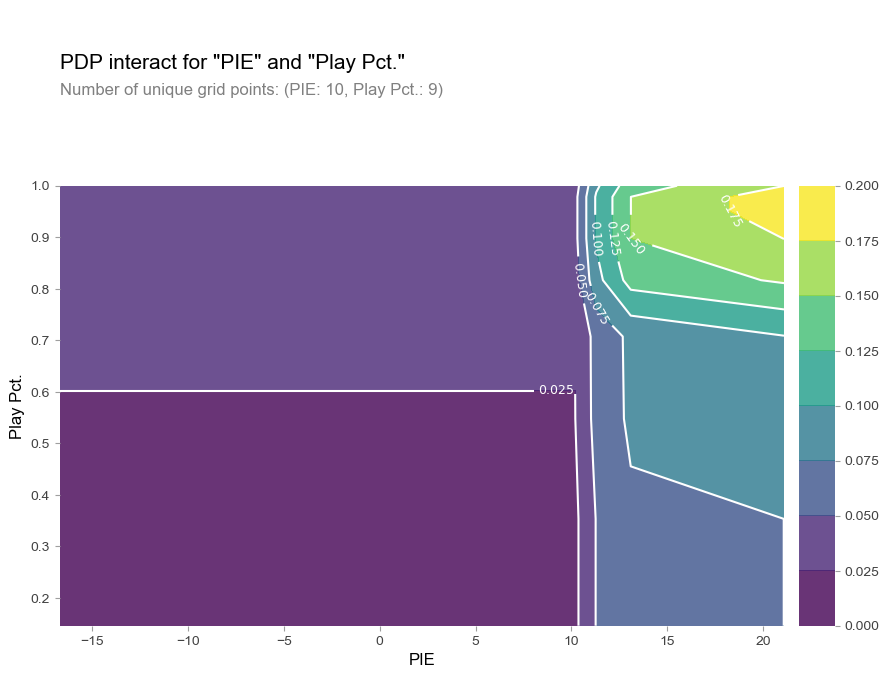

In [15]:
show_model_interpretation()

## Model Classification Metrics

In [16]:
show_classification_metrics()

,Score
Metric,
Accuracy,0.975151
Precision,0.784314
Recall,0.842105
F1 Score,0.812183
Log. Loss,0.103545
ROC AUC,0.989187


## Model Application to Current Players

In [17]:
# the following section applies the tuned model to all the active players in the current season
# the classifiction schema here takes the top 12 prediction probabilities from each
# conference, slightly different than our fixed threshold


df_to_predict = df_to_predict[features]
df_to_predict['AS Prob.'] = [prob[1] for prob in tuned_model.predict_proba(df_to_predict)]

# saving this for later to do some case-by-case analysis
df_predictions = df_to_predict.copy().join(names_and_teams)

df_to_predict = df_to_predict.join(names_and_teams)[['PLAYER', 'TEAM', 'AS Prob.']]

eastern_conference = set(['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DET', 'IND', 'MIA',
                          'MIL', 'NYK', 'ORL', 'PHI', 'TOR', 'WAS'])
df_to_predict['Conf.'] = df_to_predict['TEAM'].map(lambda x : 'East' if x in eastern_conference else 'West')

df_east = df_to_predict[df_to_predict['Conf.'] == 'East'].sort_values('AS Prob.', ascending=False).reset_index(drop=True)
df_west = df_to_predict[df_to_predict['Conf.'] == 'West'].sort_values('AS Prob.', ascending=False).reset_index(drop=True)

for df in [df_east, df_west]:
    df['Model Prediction'] = df.index.map(lambda x : 'Yes' if x < 12 else 'No')

df_east = df_east[['PLAYER', 'TEAM', 'Conf.', 'AS Prob.', 'Model Prediction']]
df_west = df_west[['PLAYER', 'TEAM', 'Conf.', 'AS Prob.', 'Model Prediction']]

# top x players per conference to include in the summary
summary_conf_size = 25

df_results_summary = pd.concat([df_east.head(summary_conf_size), df_west.head(summary_conf_size)]).set_index('PLAYER')
df_results_full = pd.concat([df_east, df_west]).set_index('PLAYER').sort_values('AS Prob.', ascending=False)

df_results_summary.to_csv('{}_NBA_ASG_predictor_results_summary.csv'.format(prediction_year))
df_results_full.to_csv('{}_NBA_ASG_predictor_results_full.csv'.format(prediction_year))

## Predictions for 2020 All-Star Game Selection

### Eastern Conference

In [18]:
df_east.head(summary_conf_size).set_index('PLAYER')

,TEAM,Conf.,AS Prob.,Model Prediction
PLAYER,,,,
Giannis Antetokounmpo,MIL,East,0.995914,Yes
Jimmy Butler,MIA,East,0.986528,Yes
Khris Middleton,MIL,East,0.972227,Yes
Jayson Tatum,BOS,East,0.966260,Yes
Kemba Walker,BOS,East,0.960982,Yes
Pascal Siakam,TOR,East,0.949431,Yes
Domantas Sabonis,IND,East,0.932390,Yes
Kyle Lowry,TOR,East,0.900801,Yes
Bam Adebayo,MIA,East,0.899604,Yes


### Western Conference

In [19]:
df_west.head(summary_conf_size).set_index('PLAYER')

,TEAM,Conf.,AS Prob.,Model Prediction
PLAYER,,,,
Anthony Davis,LAL,West,0.995695,Yes
LeBron James,LAL,West,0.995578,Yes
James Harden,HOU,West,0.992265,Yes
Damian Lillard,POR,West,0.983652,Yes
Kawhi Leonard,LAC,West,0.981010,Yes
Russell Westbrook,HOU,West,0.976483,Yes
Luka Doncic,DAL,West,0.970403,Yes
Nikola Jokic,DEN,West,0.970189,Yes
Donovan Mitchell,UTA,West,0.964947,Yes


## Investigating Edge Cases

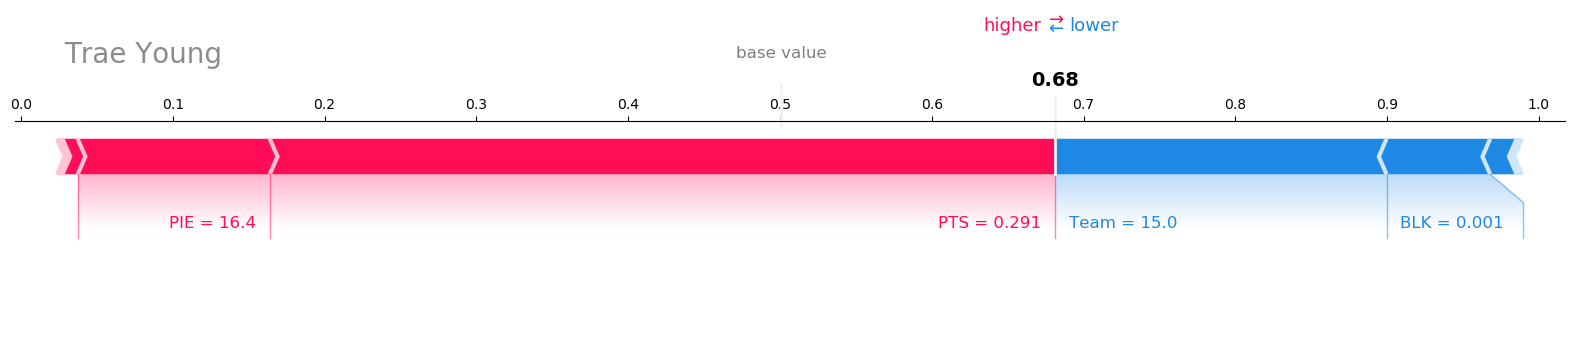

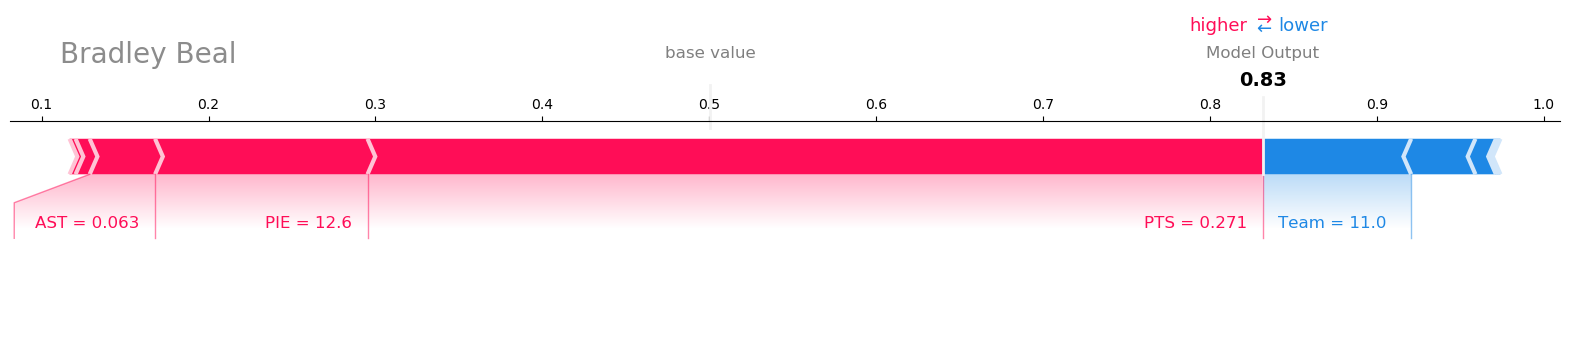

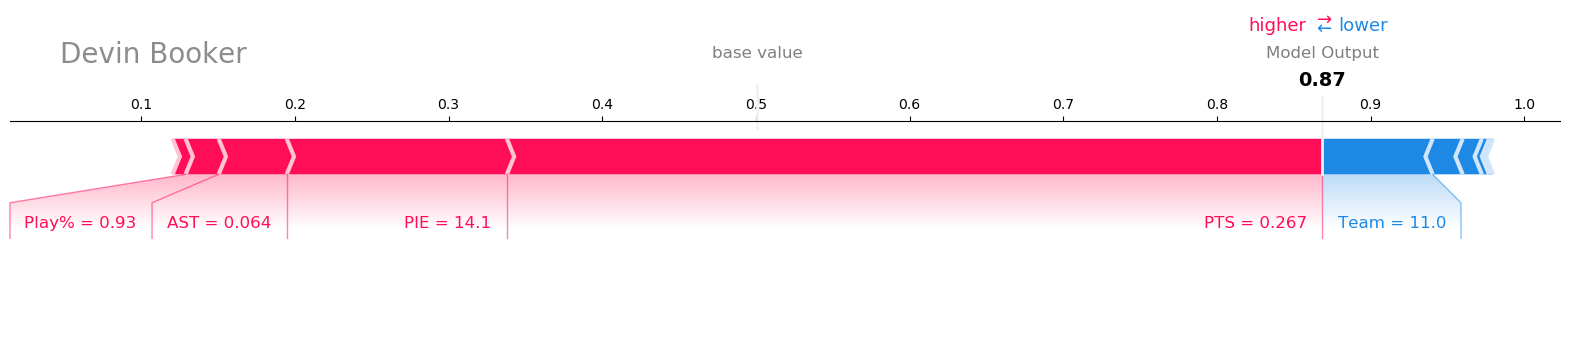

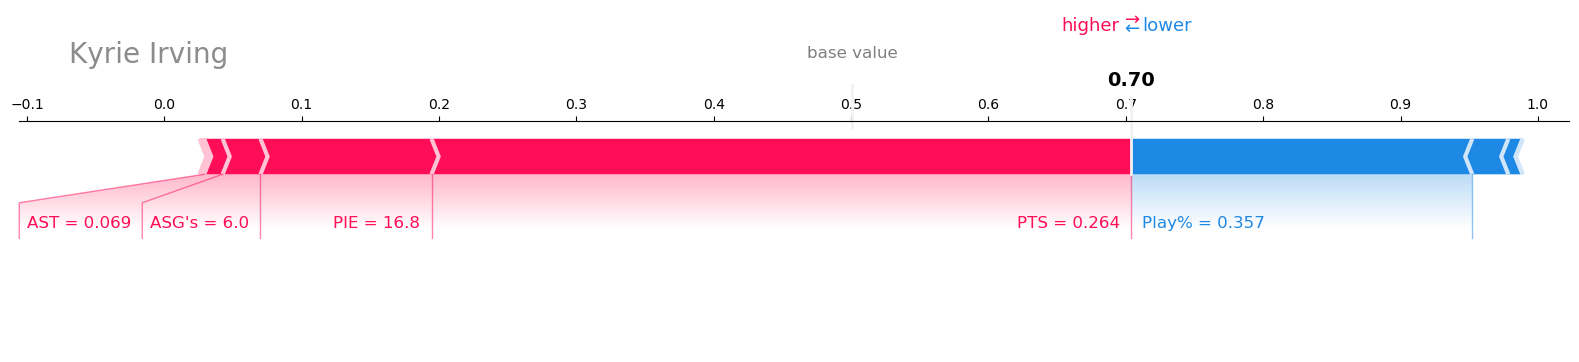

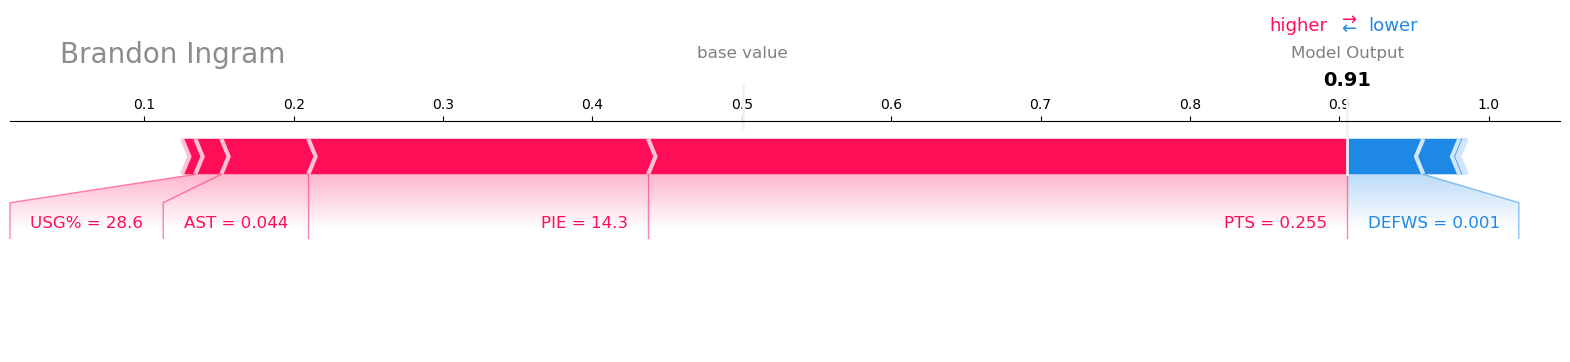

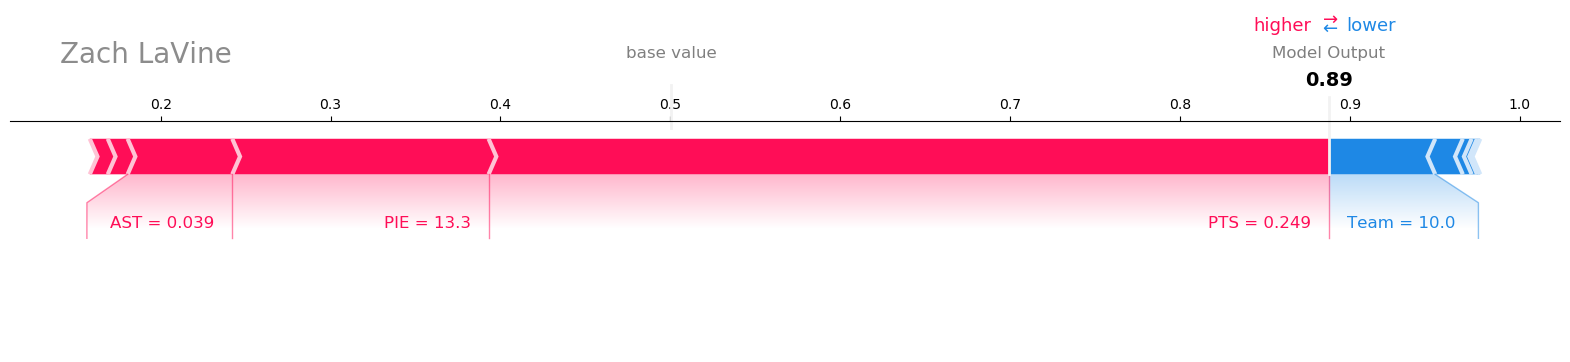

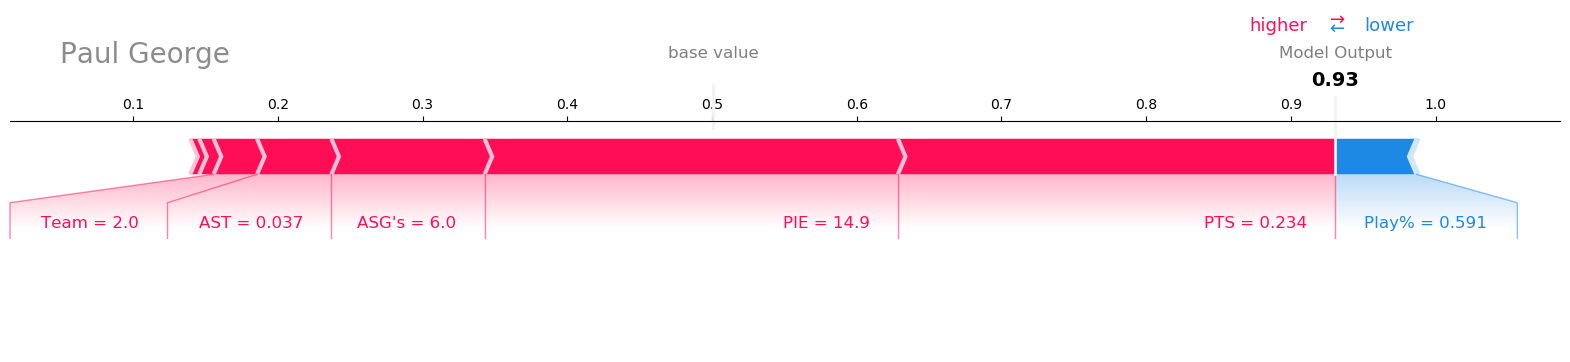

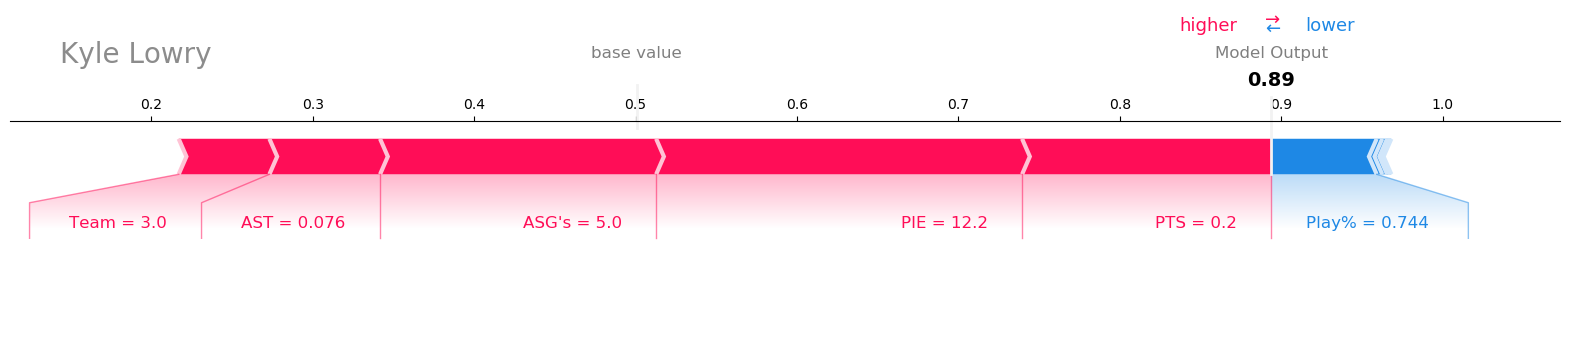

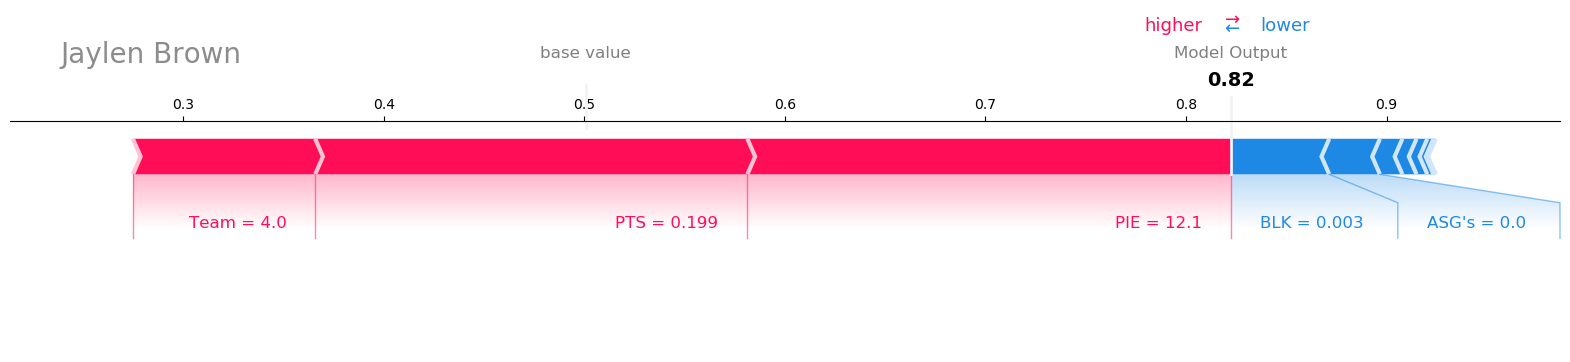

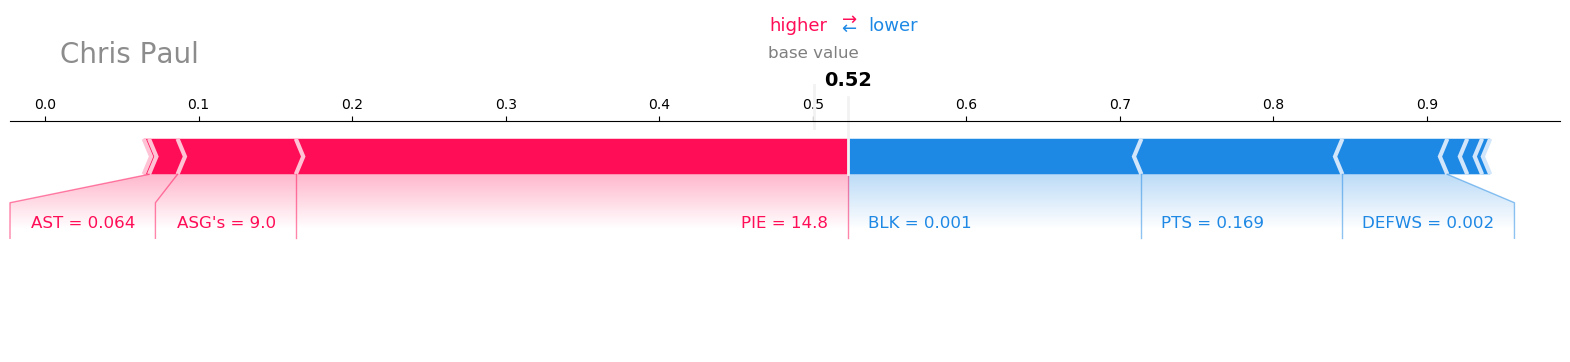

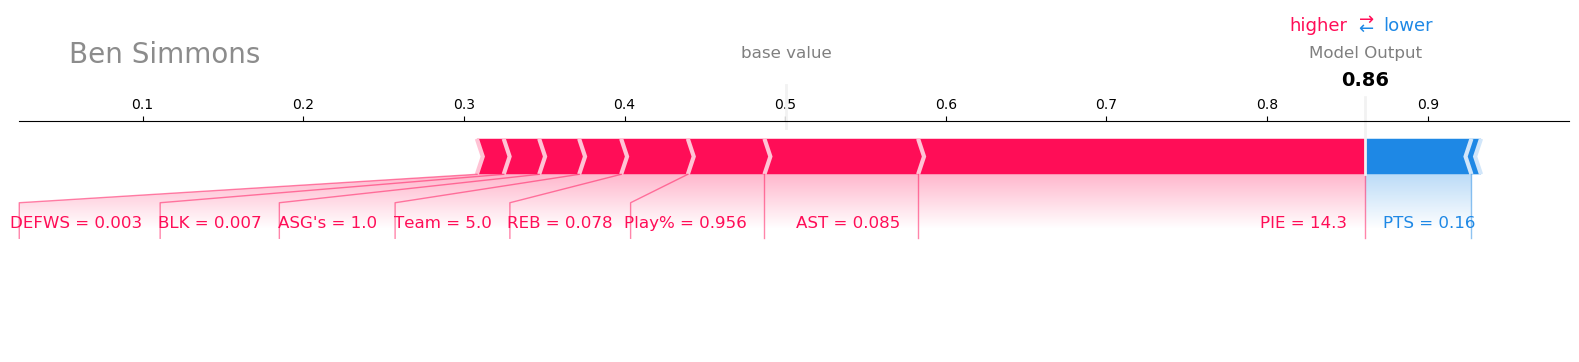

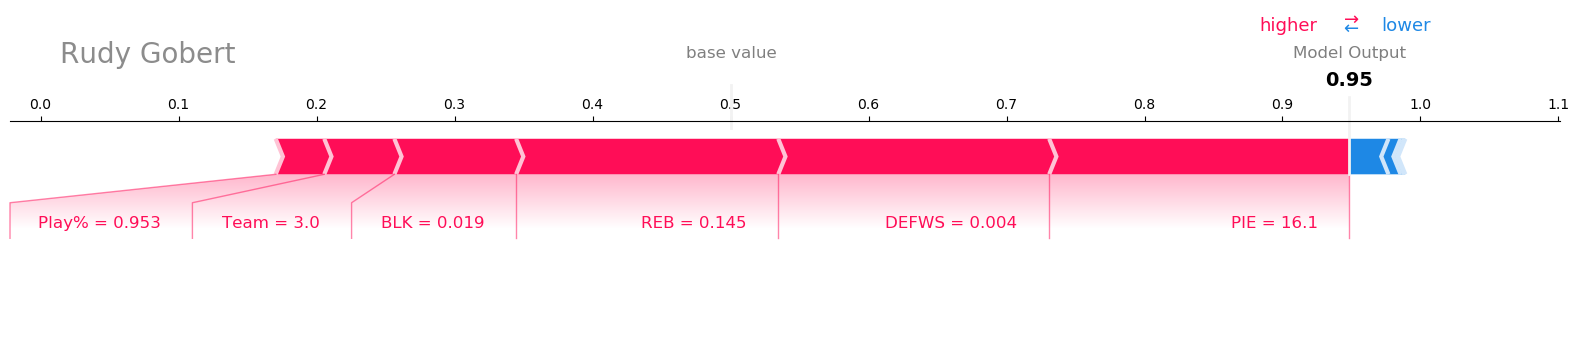

In [20]:
players_to_investigate = [
    'Zach LaVine',
    'Trae Young',
    'Paul George',
    'Chris Paul',
    'Devin Booker',
    'Kyle Lowry',
    'Rudy Gobert',
    'Jaylen Brown',
    'Bradley Beal',
    'Ben Simmons',
    'Brandon Ingram',
    'Kyrie Irving'
]

df_investigation = df_predictions[df_predictions['PLAYER'].isin(players_to_investigate)]
investigation_names = list(df_investigation['PLAYER'])
df_investigation = df_investigation[features]
explainer = shap.TreeExplainer(tuned_model)

# if true, will display the html/js rendering of the shap force plot
# otherwise, the matplotlib version will be displayed
disp_html = False

if disp_html:
    shap.initjs()

for i in range(len(df_investigation)):
    
    player_name = investigation_names[i]
    
    # fix issue where way too many digits of each feature was being displayed in the matplotlib plot
    df_investigation.iloc[i] = df_investigation.iloc[i].map(lambda x : round (x, 3))
    
    player_shap_values = explainer.shap_values(df_investigation.iloc[i])
    
    # fix text overlap issues
    base = expit(explainer.expected_value)
    pred = expit(sum(player_shap_values[0]))
    out_name = '' if abs(pred-base) < 0.25 else 'Model Output'
    
    force_html = shap.force_plot(explainer.expected_value, player_shap_values, df_investigation.iloc[i],
                           link='logit', out_names=out_name, feature_names=feature_short_labels)
    
    if disp_html:
        print(player_name)
        display(force_html)
    
    fig = shap.force_plot(explainer.expected_value, player_shap_values, df_investigation.iloc[i],
                    link='logit', out_names=out_name, feature_names=feature_short_labels,
                    show=False, matplotlib=True)
    fig.suptitle(player_name, x=0.15, y=1.15, color='#8c8c8c', va='top', ha='left', size=20)
    plt.savefig('./Plots/fp_{}'.format(player_name.replace(' ', '_')), bbox_inches='tight')
    
    if not disp_html:
        plt.show()
        
    plt.close()